In [36]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data, generate_dataset_g
from nn_modules import View
from nn_models import LeNet, aliG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.4.1


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

## Loading the data (MNIST)

In [4]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=False)

train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [5]:
print("# of training samples : "+str(len(train_input)))

# of training samples : 1000


## 1) LeNet with disjoint trainset and testset

In [6]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [7]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                       0.02129           0.300         0.00189           0.345
10                      0.00177           0.952         0.00045           0.866
20                      0.00035           0.993         0.00025           0.923
30                      0.00008           1.000         0.00020           0.930
40                      0.00004           1.000         0.00020           0.934
49                      0.00003           1.000         0.00020           0.933
*******************************************************************************


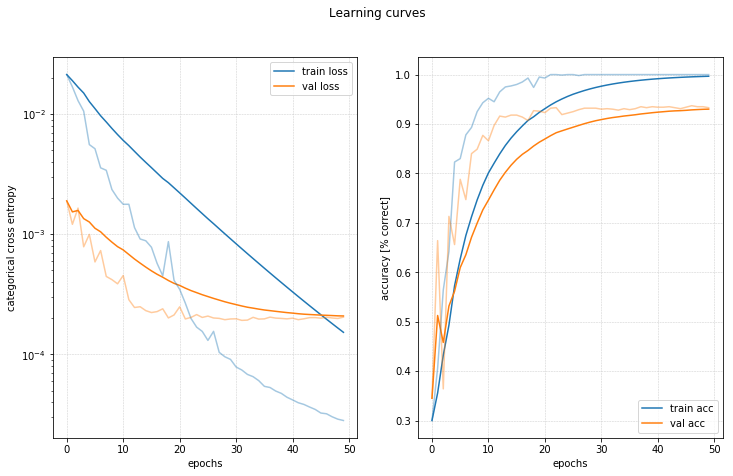

In [8]:
model = LeNet()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=50, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Extract layers activations examples

In [9]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [10]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
output_d, handles_d  = spyOn([model.conv2, model.fc1], ['convolution 2', 'FC_1'], True)

In [11]:
model(train_input[0:10].reshape(-1, 1, 28, 28))

captured output at layer : Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
captured output at layer : Linear(in_features=256, out_features=200, bias=True)


tensor([[ -0.4076,  -2.4919,  -1.6008,   9.7636, -12.7767,  18.4292,  -4.6458,
          -5.1658,   5.7147,  -4.4175],
        [ 17.8785,  -9.0600,  -0.8488,  -9.4121,  -6.7512,   4.0858,   1.8125,
           1.6774,  -6.1374,   6.2579],
        [ -9.6790,  -1.6393,   4.4084,   0.9091,  16.7936,  -4.6048,  -3.9737,
           2.8509,  -7.3772,   5.3707],
        [ -3.9110,  15.6076,   3.0532,  -5.7444,   0.7424,  -6.0770,   0.2178,
           2.3255,   2.9835,  -7.7827],
        [ -6.5298,  -2.1875,  -7.0071,  -2.2170,   8.9742,  -1.9401,  -8.7407,
           3.0478,   2.0882,  16.7160],
        [ -1.3882,  -3.6486,  10.9131,   3.1163,  -7.5441,  -0.1394,  -4.0897,
           2.6732,   3.9460,   1.2487],
        [ -9.1394,  12.2945,  -0.0186,  -0.6892,   0.7097,   0.5454,  -0.4012,
          -0.1309,   3.5336,  -4.7355],
        [ -4.3497,  -4.2543,   7.1932,  22.0540, -14.3066,   3.3855, -13.3572,
          -0.6264,   6.9763,   0.9715],
        [ -7.0785,  12.9132,  -2.5201,  -3.4791,

In [12]:
output_d['convolution 2'].reshape(10, -1).shape

torch.Size([10, 1024])

In [13]:
remove_spying(handles_d)

## 3) Differentiate layer activation from training sample than one from a testing sample

In [14]:
#Size of input vector can be changed
modelG = aliG(142)

In [15]:
debug_layers_dims(modelG, [1, 1, 142])

******************** Debugging layers sizes: ********************
input_shape= (_,1,142)
------------------
Conv1d(1, 32, kernel_size=(8,), stride=(1,))
(_,1,142) --> (_,32,135)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,32,135) --> (_,32,67)
------------------
Conv1d(32, 128, kernel_size=(5,), stride=(1,))
(_,32,67) --> (_,128,63)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,128,63) --> (_,128,31)
------------------
Conv1d(128, 16, kernel_size=(3,), stride=(1,))
(_,128,31) --> (_,16,29)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,16,29) --> (_,16,14)
------------------
View(_, [-1])
(_,16,14) --> (_,224)
------------------
Linear(in_features=224, out_features=100, bias=True)
(_,224) --> (_,100)
------------------
Linear(in_features=100, out_features=32, bias=True)
(_,100) --> (_,32)
------------------
Linear(in_features=32, out_

tensor([[0.0396],
        [0.0387]], grad_fn=<ThAddmmBackward>)

In [37]:
layer = model.fc1
layer_name = "fc1"

In [38]:
(g_train_dataset, g_test_dataset) = generate_dataset_g(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7)

In [42]:
g_train_dataset[0][1000:1010].shape

torch.Size([10, 1, 200])

In [26]:
size_input_vector = g_train_dataset[0].shape[2]
print("size of input vector :", size_input_vector)

size of input vector : 200


In [27]:
g_train_dataset[1].shape

torch.Size([1400])

In [28]:
g_train_dataset[1][0:10]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
modelG = aliG(size_input_vector)

In [33]:
modelG(g_train_dataset[0][0:10]).squeeze(1)

tensor([0.5232, 0.5253, 0.5229, 0.5232, 0.5195, 0.5235, 0.5251, 0.5215, 0.5257,
        0.5213], grad_fn=<SqueezeBackward1>)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                       0.00695          50.756         0.00116         300.000
4                       0.00656          49.719         0.00106         300.000
8                       0.00608          50.246         0.00104         300.000
12                      0.00569          49.940         0.00105         300.000
16                      0.00520          50.430         0.00104         300.000
20                      0.00483          50.314         0.00119         300.000
24                      0.00464          49.743         0.00110         300.000
28                      0.00391          50.631         0.00129         300.000
32                      0.00331          50.309         0.00140         300.000
36                      0.00300          50.089         0.00153         300.000
39                      0.00283         

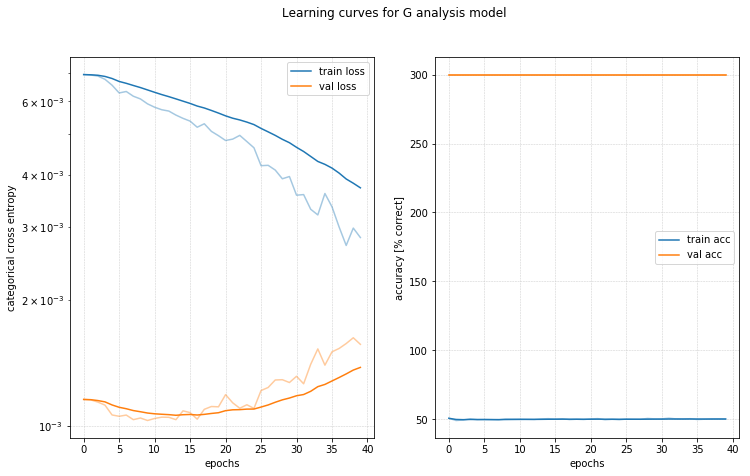

In [35]:
crit_fun = lambda input_, target : (input_.squeeze(1), target)
y_hat_fun = lambda y: y.round()

loss_fun = nn.BCELoss()
learning_rate = 0.005

mt = ModelTrainer(modelG, loss_fun, optim.Adamax(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=40, batch_size=100, verbose=4)
mt.plot_training("Learning curves for G analysis model")